In [64]:
import os

# Define the directory containing the images
root_dir = 'streamlit-app/images'

# Initialize an empty list to store the image paths
image_paths = []

# Walk through the directory tree
for root, dirs, files in os.walk(root_dir):
    for file in files:
        # Check if the file is an image (you can adjust the condition based on your image file extensions)
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
            # Construct the full path of the image file
            image_path = os.path.join(root, file)
            # Append the image path to the list
            image_paths.append(image_path)


In [65]:
len(image_paths)

5974

In [3]:
import chromadb
from chromadb import Client, Settings
client = chromadb.Client(Settings(is_persistent=True, persist_directory="./clip_chroma"))

In [66]:
import openai, os
os.environ['OPENAI_API_KEY'] =""
openai.api_key =""

In [67]:
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction
from chromadb.utils.data_loaders import ImageLoader

embedding_function = OpenCLIPEmbeddingFunction()
image_loader = ImageLoader()

In [68]:
from PIL import Image
import torch
import clip

# set the device to use for the CLIP model, either CUDA (GPU) or CPU, depending on availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

model, preprocess = clip.load("ViT-B/32", device=device)
print(clip.available_models())

# img_emb_dict stores image embeddings for each image
img_emb_dict = {}
with torch.no_grad():

    # iterate over the image metadata dictionary and extracts image embeddings for each image
    for image_id in image_paths:
        # img_file_path = image_metadata_dict[image_id]["img_path"]
        if os.path.isfile(image_id):
            image = (
                # preprocess the image using the CLIP model's preprocess function
                # unsqueeze the image tensor to add a batch dimension
                # move the image tensor to the device specified in line 2
                preprocess(Image.open(image_id)).unsqueeze(0).to(device)
            )
            # extract image features using the CLIP model's encode_image function
            image_features = model.encode_image(image)

            # store the image features in the image embedding dictionary
            img_emb_dict[image_id] = image_features

cpu
['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']


In [69]:
from llama_index.core.schema import ImageDocument
image_documents =[]
for key,value in img_emb_dict.items():
    newImgDoc = ImageDocument(text=key,metadata={"filepath": key},embedding=value.tolist()[0])
    image_documents.append(newImgDoc)


In [70]:
image_documents[0]

ImageDocument(id_='71ff1af8-91fe-4069-b10d-d873f2c0e326', embedding=[-0.2359676957130432, -0.04050429165363312, 0.5427489876747131, -0.09223450720310211, -0.08354069292545319, 0.012668196111917496, -0.002935662865638733, 0.04134061560034752, 0.045104093849658966, -0.17022085189819336, 0.13568049669265747, 0.04923577979207039, 0.34785348176956177, -0.0687917023897171, 0.20363971590995789, -0.14412832260131836, 0.2669370472431183, -0.06515662372112274, 0.09303848445415497, -0.08139762282371521, -0.1733810007572174, -0.21123740077018738, 0.33161091804504395, -0.3029259741306305, -0.006819114089012146, 0.23615190386772156, 0.25098976492881775, 0.18056535720825195, 0.02170911431312561, -0.1796281933784485, 0.33466893434524536, -0.45282819867134094, -0.35778671503067017, 0.05313973128795624, 0.07367665320634842, 0.20053377747535706, 0.03467651829123497, 0.42442786693573, 0.1108478307723999, 1.6361665725708008, -0.6080709099769592, -0.03778756037354469, 0.2558206021785736, -0.1124141812324523

In [71]:
chroma_client = chromadb.Client(Settings(is_persistent=True, persist_directory="./final_chroma_db"))
chroma_collection = chroma_client.create_collection(
    "images_collection",
    embedding_function=embedding_function,
    data_loader=image_loader,
)

In [72]:
# set up ChromaVectorStore and load in data
from llama_index.vector_stores.chroma import ChromaVectorStore
from llama_index.core import VectorStoreIndex
from llama_index.core import SimpleDirectoryReader, StorageContext
vector_store = ChromaVectorStore(chroma_collection=chroma_collection)
storage_context = StorageContext.from_defaults(vector_store=vector_store)
index = VectorStoreIndex.from_documents(
    image_documents,
    storage_context=storage_context,
)

In [98]:
from PIL import Image
import torchvision.transforms as transforms

# Load the query image
query_image_path = "IMG_1626.jpg"
query_image = Image.open(query_image_path)

# Preprocess the query image and convert it to a tensor
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
query_image_tensor = preprocess(query_image).unsqueeze(0)

image_features = model.encode_image(query_image_tensor).tolist()[0]

In [99]:
res = chroma_collection.query(image_features)

In [100]:
res['documents']

[['streamlit-app/images/FotosDiego/W8W-1873-MARFIL (4).jpg',
  'streamlit-app/images/FotosDiego/W0X-0552CL-STONE (4).jpg',
  'streamlit-app/images/FotosDiego/W4X-1557-NATA (4).jpg',
  'streamlit-app/images/FotosDiego/1489-A829P-OFF WHITE (4).jpg',
  'streamlit-app/images/FotosDiego/1489-3498S-COBRE (4).jpg',
  'streamlit-app/images/FotosDiego/W7W-1751-NATA (3).jpg',
  'streamlit-app/images/FotosDiego/W1B-1974CL-CHAMPAGNE (3).jpg',
  'streamlit-app/images/FotosDiego/W8P-5879CPC1-MARFIL (4).jpg',
  'streamlit-app/images/FotosDiego/W8W-1510C1-NATA (4).jpg',
  'streamlit-app/images/FotosDiego/1637-A956S-ORO (4).jpg']]

In [101]:
from PIL import Image
import matplotlib.pyplot as plt
import os
def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(3, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 9:
                break

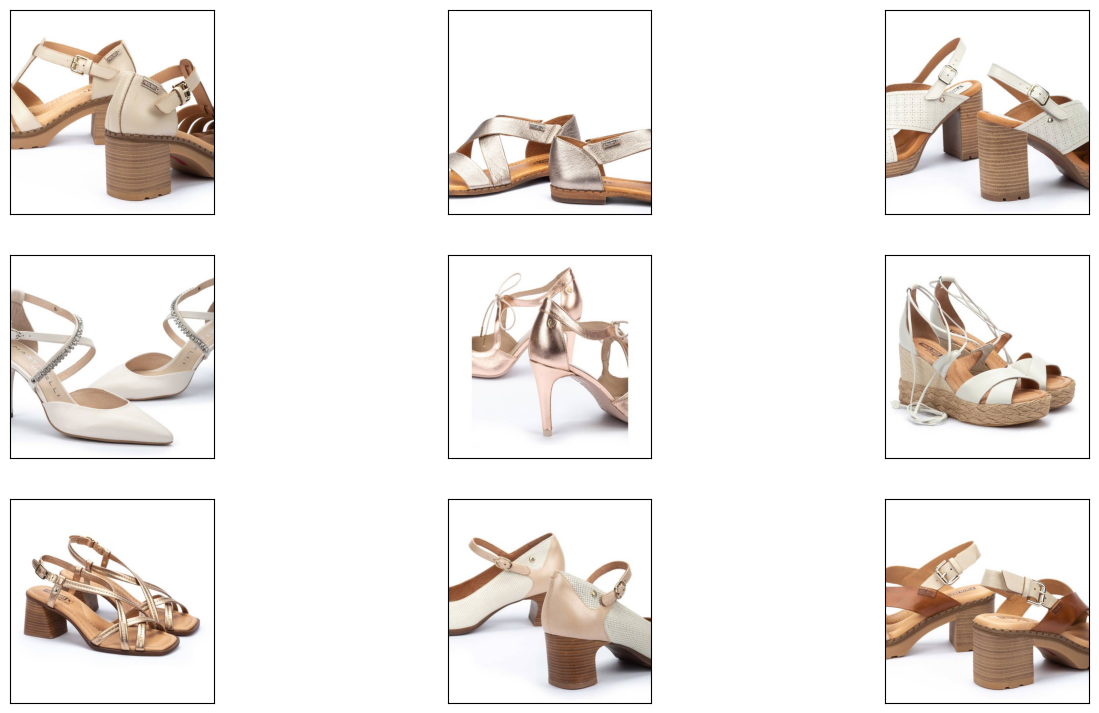

In [102]:
plot_images(res['documents'][0])